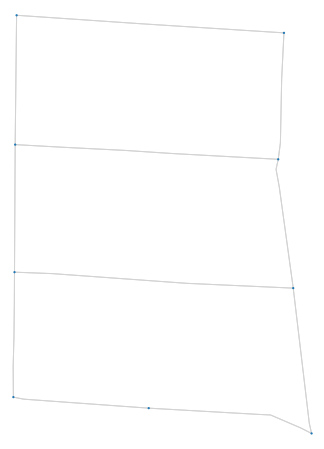

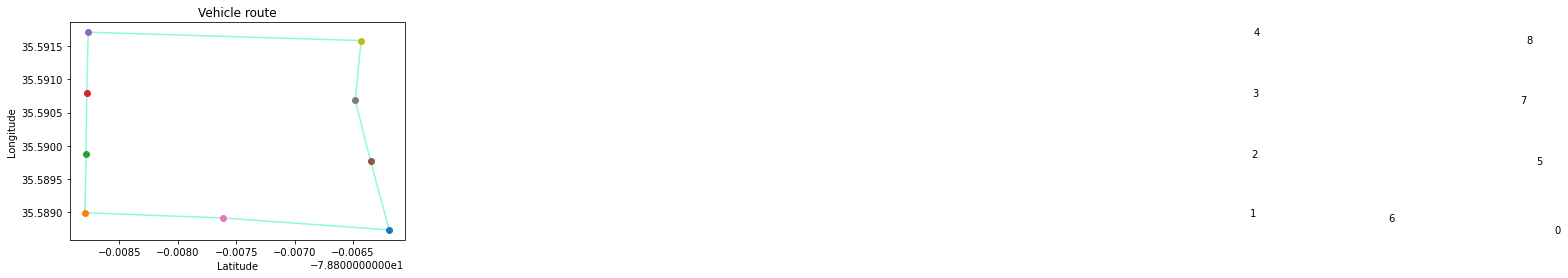

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]
2
1
6
0
5
7
8
4
3


In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#Creating a bounding box
north, south, east, west = 35.588654,35.591812,-78.808848,-78.806101
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost


for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != 2 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != 2 and j!= 2) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=2:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [2]:
routes[0][3][0]

0

In [3]:
routes

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]

In [4]:
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 

2
1
6
0
5
7
8
4
3


In [2]:
bb1 = [35.588654,35.591812,-78.808848,-78.806101]

In [6]:
type(bb1)

list

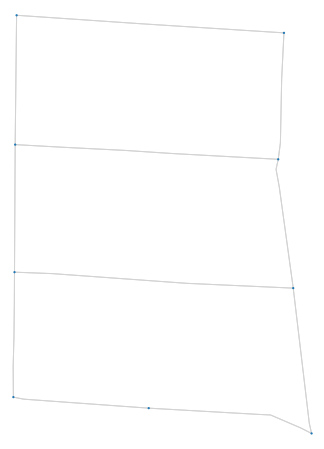

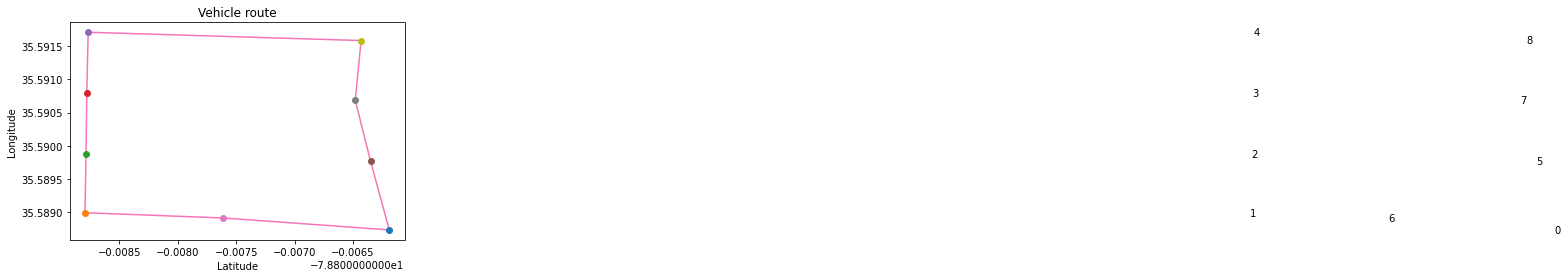

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]
2
1
6
0
5
7
8
4
3


In [7]:


#Creating a bounding box
north, south, east, west = bb1[0],bb1[1],bb1[2],bb1[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [3]:
bb1

[35.588654, 35.591812, -78.808848, -78.806101]

In [4]:
depot1 = 2

In [5]:
bb2 = [35.581702,35.584546,-78.800222,-78.797915]

In [6]:
depot2 = 8

In [10]:
data.index.stop-1

In [7]:
bb = []
bb.append(bb1)
bb.append(bb2)

In [8]:
for i in range(2):
    print(bb[i][0])

35.588654
35.581702


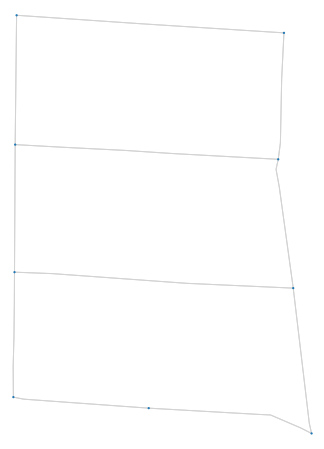

       0      1      2      3      4      5      6      7      8
0    0.0  239.2  337.9  438.7  540.9  115.7  131.9  218.7  318.7
1  239.2    0.0   98.7  199.4  301.7  319.3  107.3  407.6  513.3
2  337.9   98.7    0.0  100.8  203.0  220.6  206.0  308.9  414.6
3  438.7  199.4  100.8    0.0  102.2  321.4  306.8  208.2  313.9
4  540.9  301.7  203.0  102.2    0.0  423.6  409.0  310.4  211.7
5  115.7  319.3  220.6  321.4  423.6    0.0  247.7  102.9  203.0
6  131.9  107.3  206.0  306.8  409.0  247.7    0.0  350.6  450.6
7  218.7  407.6  308.9  208.2  310.4  102.9  350.6    0.0  100.0
8  318.7  513.3  414.6  313.9  211.7  203.0  450.6  100.0    0.0


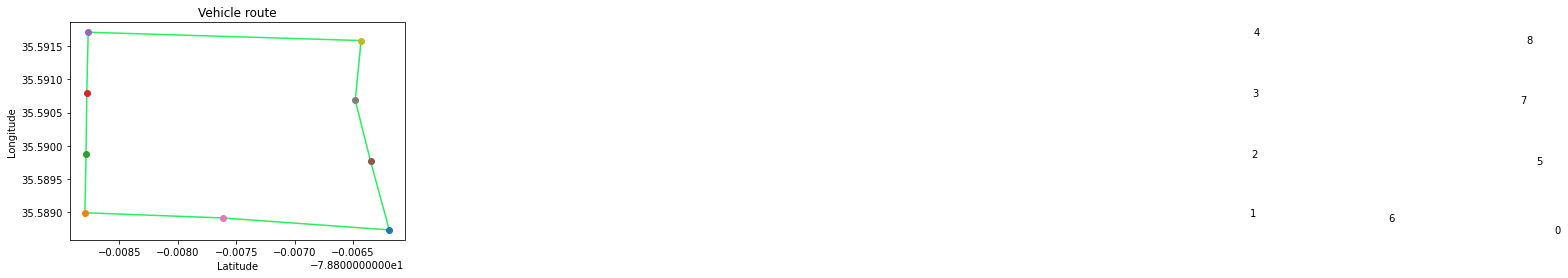

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]


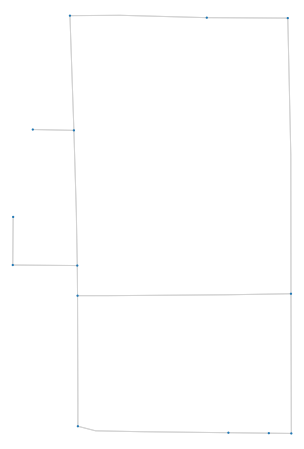

       0      1      2      3      4      5      6      7      8      9   \
0     0.0  135.3  397.7  101.7  187.2  259.8  217.7   82.6  346.4  213.3   
1   135.3    0.0  262.8  237.0  322.6  395.1   88.4  218.0  314.1  348.6   
2   397.7  262.8    0.0  296.0  210.4  137.9  174.4  315.0   51.3  236.5   
3   101.7  237.0  296.0    0.0   85.6  158.1  154.1   19.0  244.7  111.6   
4   187.2  322.6  210.4   85.6    0.0   72.6  239.6  104.6  159.2   26.1   
5   259.8  395.1  137.9  158.1   72.6    0.0  312.2  177.1   86.6   98.6   
6   217.7   88.4  174.4  154.1  239.6  312.2    0.0  135.1  225.7  265.7   
7    82.6  218.0  309.5   19.0  104.6  177.1  135.1    0.0  263.7  130.6   
8   346.4  314.1   51.3  244.7  159.2   86.6  225.7  263.7    0.0  185.2   
9   333.6  469.0  356.9  232.0  146.4  219.0  386.1  251.0  305.6    0.0   
10  142.5  277.8  336.8   40.8  126.4  198.9  194.9   59.8  285.5  152.4   
11  172.9  308.3  367.3   71.3  156.8  229.4  225.4   90.3  316.0  182.9   
12  121.1   

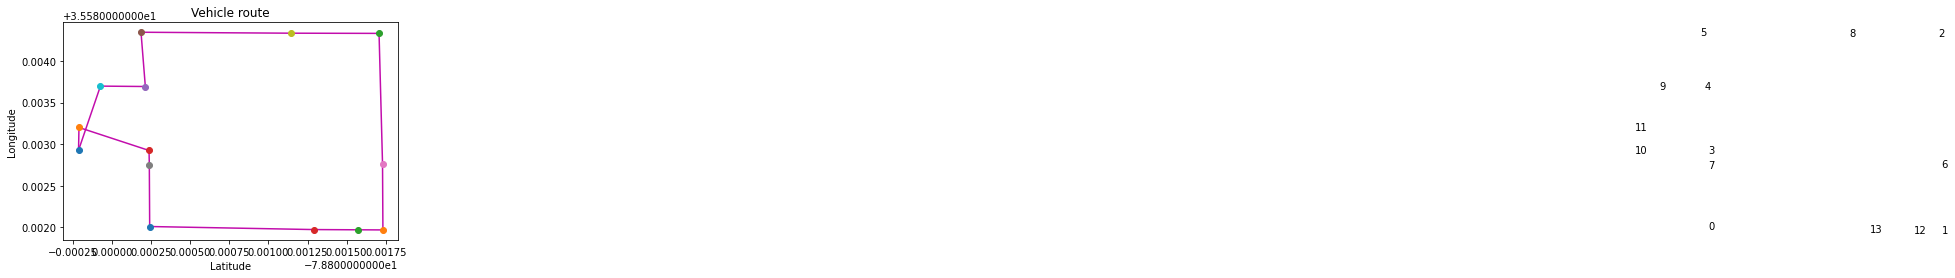

[[(2, 8), (8, 5), (5, 4), (4, 9), (9, 10), (10, 11), (11, 3), (3, 7), (7, 0), (0, 13), (13, 12), (12, 1), (1, 6), (6, 2)]]


In [16]:
for i in range(2):
    
    #Creating a bounding box
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)

    data = pd.DataFrame(Nodes)
    data.rename(columns = {0:'Nodes'}, inplace = True)

    lat1 = []
    long1 = []
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data['Latitude'] = lat1
    data['Longitude'] = long1
    df1 = data


    df1 = df1.drop(['Nodes'],axis=1)
    df1.rename(columns = {'Latitude':'Left'}, inplace = True)
    df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
    df3 = pd.DataFrame()
    for j in df1.index:
        list1 = []
        for i in df1.index:
            r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
            list1.append(json.loads(r.content)["routes"][0]["distance"])
        df3[j] = list1
    df = df1
    df['coordinate'] = list(zip(df['Right'],df['Left']))
    df['ID'] = df.index

    locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
    distances_df = df3
    distance = distances_df
    distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)
    print(df3)

    ## V: This defines the total number of vehicles that will traverse the path.
    V = 1
    ## prob: This initializes the problem that will run using provided constraints.

    prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
    indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
    eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
    cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    start1 = depot1
    for v in df.ID:
        ## cap: This considers a particular node at a time. 
        cap = 1 if v != start1 else V
        #inward possible route
        prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
        prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
    num=len(df.ID)/V
    for i in df.ID:
        for j in df.ID:
            if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
                prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1


    prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
    feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
    def get_next_loc(initial):
        edges = [e for e in feasible_edges if e[0]==initial]
        for e in edges:
            feasible_edges.remove(e)
        return edges
    ## routes: This stores information regarding paths.    
    routes = get_next_loc(2)
    routes = [ [e] for e in routes ]

    for r in routes:
        while r[-1][1] !=start1:
            r.append(get_next_loc(r[-1][1])[-1])
    ## coloured_loc: This stores information according to individual paths.        
    coloured_loc = [np.random.rand(3) for i in range(len(routes))]
    for r,co in zip(routes,coloured_loc):
        for a,b in r:
            l1,l2 = locations[a], locations[b]
            plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
    for l in locations:
        lo = locations[l]
        plt.plot(lo[0],lo[1],'o')
        plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')


    plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()        

    print(routes)
    ##@ package create_data_model
    # Stores the data for the problem.
    def create_data_model():
        data = {}
        data['distance_matrix'] = distance

        data['num_vehicles'] = 5

        data['num_vehicles'] = 3

        data['depot'] = 7
        return data

    ##@print_solution
    #Prints solution on console.
    def print_solution(data, manager, routing, solution):

        max_route_distance = 0
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            while not routing.IsEnd(index):
                plan_output += ' {} -> '.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += '{}\n'.format(manager.IndexToNode(index))
           #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            print(plan_output)
            max_route_distance = max(route_distance, max_route_distance)
        #print('Maximum of the route distances: {}m'.format(max_route_distance))

    ##@main
    #Solve the CVRP problem.
    def main():
        # Instantiate the data problem.
        data = create_data_model()
        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])
        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        # Create and register a transit callback.
        ##Returns the distance between the two nodes.
        def distance_callback(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Add Distance constraint.
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            3000,  # vehicle maximum travel distances
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        # Print solution on console.
        #if solution:
            #print_solution(data, manager, routing, solution)
    if __name__ == '__main__':
        main()


    #Visualization
    df2 = df[['Left', 'Right', 'ID']].copy()
    df2.rename(columns = {'Left':'Latitude'}, inplace = True)
    df2.rename(columns = {'Right':'Longitude'}, inplace = True)
    #Creating a list from routes to reorder the indexes
    a=[]
    for i in range(data.index.stop):
        #print(routes[0][i][0])
        a.append(routes[0][i][0]) 
    order1 = [1,6,0,5,2]
    order2 = [7,8,4,3,2]
    df3 = pd.DataFrame()
    for i in a:
        df3 = df3.append(df2.loc[i])
    df4 = pd.DataFrame()
    for i in order2:
        df4 = df4.append(df2.loc[i])
    df3.reset_index(inplace = True)
    df4.reset_index(inplace = True)

    df3 = df3.append(df3.loc[0])
    df4 = df4.append(df4.loc[0])
    df3.reset_index(inplace = True)
    long2 = [] 
    lat2 = []  
    for i in df3.index:
        long2.append(df3.loc[i]["Longitude"])
        lat2.append(df3.loc[i]["Latitude"])

    df4.reset_index(inplace = True)
    long3 = [] 
    lat3 = []  
    for i in df4.index:
        long3.append(df4.loc[i]["Longitude"])
        lat3.append(df4.loc[i]["Latitude"])


    def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()


    origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
    destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

    origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
    destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
    plot_path(lat2, long2, origin_point2, destination_point2)
    #plot_path(lat3, long3, origin_point3, destination_point3)

In [17]:
routes

[[(2, 8),
  (8, 5),
  (5, 4),
  (4, 9),
  (9, 10),
  (10, 11),
  (11, 3),
  (3, 7),
  (7, 0),
  (0, 13),
  (13, 12),
  (12, 1),
  (1, 6),
  (6, 2)]]

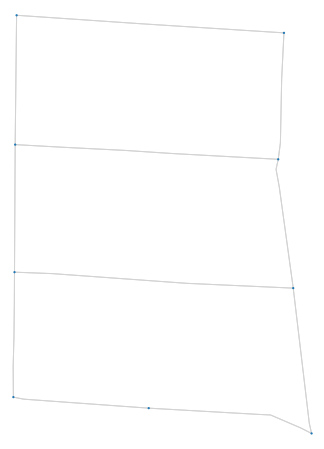

       0      1      2      3      4      5      6      7      8
0    0.0  239.2  337.9  438.7  540.9  115.7  131.9  218.7  318.7
1  239.2    0.0   98.7  199.4  301.7  319.3  107.3  407.6  513.3
2  337.9   98.7    0.0  100.8  203.0  220.6  206.0  308.9  414.6
3  438.7  199.4  100.8    0.0  102.2  321.4  306.8  208.2  313.9
4  540.9  301.7  203.0  102.2    0.0  423.6  409.0  310.4  211.7
5  115.7  319.3  220.6  321.4  423.6    0.0  247.7  102.9  203.0
6  131.9  107.3  206.0  306.8  409.0  247.7    0.0  350.6  450.6
7  218.7  407.6  308.9  208.2  310.4  102.9  350.6    0.0  100.0
8  318.7  513.3  414.6  313.9  211.7  203.0  450.6  100.0    0.0


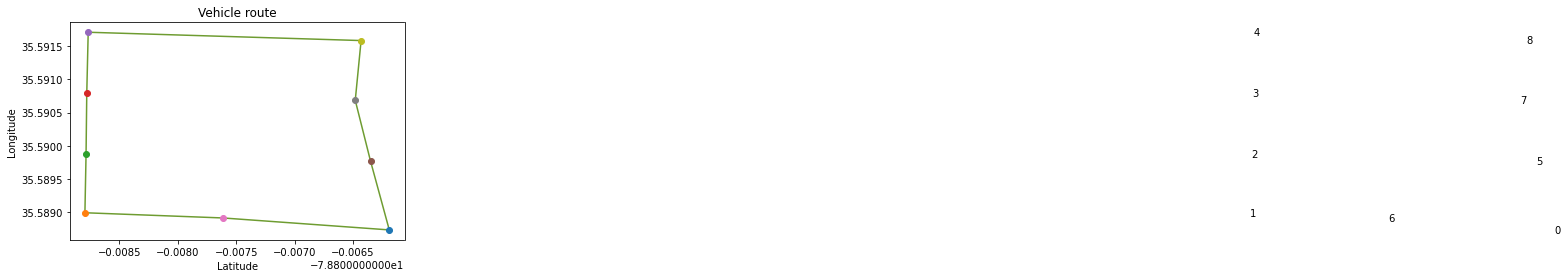

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]


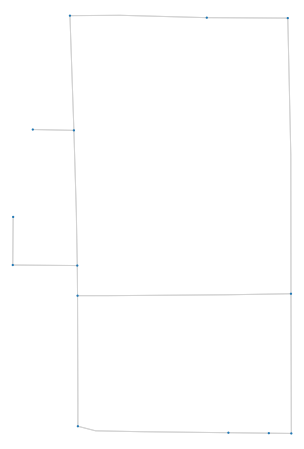

       0      1      2      3      4      5      6      7      8      9   \
0     0.0  135.3  397.7  101.7  187.2  259.8  217.7   82.6  346.4  213.3   
1   135.3    0.0  262.8  237.0  322.6  395.1   88.4  218.0  314.1  348.6   
2   397.7  262.8    0.0  296.0  210.4  137.9  174.4  315.0   51.3  236.5   
3   101.7  237.0  296.0    0.0   85.6  158.1  154.1   19.0  244.7  111.6   
4   187.2  322.6  210.4   85.6    0.0   72.6  239.6  104.6  159.2   26.1   
5   259.8  395.1  137.9  158.1   72.6    0.0  312.2  177.1   86.6   98.6   
6   217.7   88.4  174.4  154.1  239.6  312.2    0.0  135.1  225.7  265.7   
7    82.6  218.0  309.5   19.0  104.6  177.1  135.1    0.0  263.7  130.6   
8   346.4  314.1   51.3  244.7  159.2   86.6  225.7  263.7    0.0  185.2   
9   333.6  469.0  356.9  232.0  146.4  219.0  386.1  251.0  305.6    0.0   
10  142.5  277.8  336.8   40.8  126.4  198.9  194.9   59.8  285.5  152.4   
11  172.9  308.3  367.3   71.3  156.8  229.4  225.4   90.3  316.0  182.9   
12  121.1   

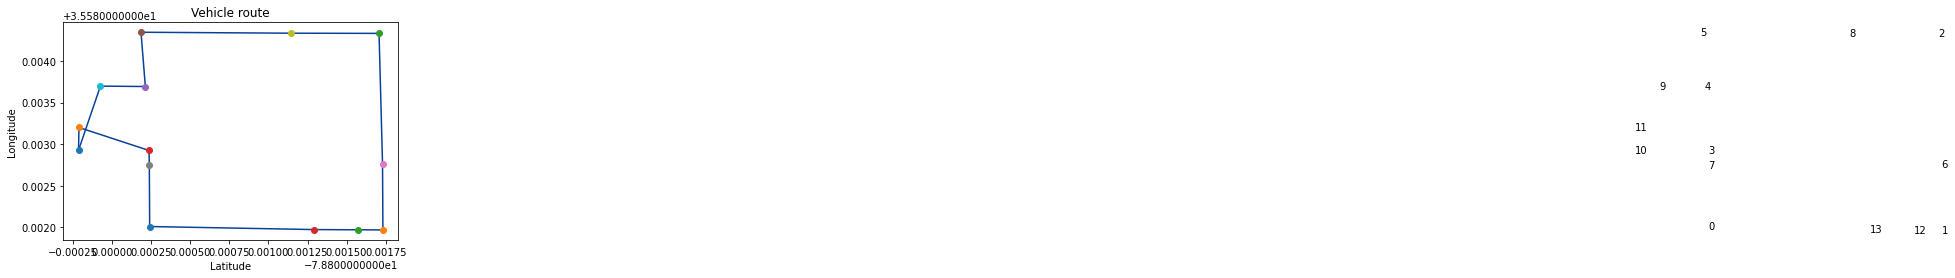

[[(2, 8), (8, 5), (5, 4), (4, 9), (9, 10), (10, 11), (11, 3), (3, 7), (7, 0), (0, 13), (13, 12), (12, 1), (1, 6), (6, 2)]]


In [18]:
for i in range(2):
    
    #Creating a bounding box
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)

    data = pd.DataFrame(Nodes)
    data.rename(columns = {0:'Nodes'}, inplace = True)

    lat1 = []
    long1 = []
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data['Latitude'] = lat1
    data['Longitude'] = long1
    df1 = data


    df1 = df1.drop(['Nodes'],axis=1)
    df1.rename(columns = {'Latitude':'Left'}, inplace = True)
    df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
    df3 = pd.DataFrame()
    for j in df1.index:
        list1 = []
        for i in df1.index:
            r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
            list1.append(json.loads(r.content)["routes"][0]["distance"])
        df3[j] = list1
    df = df1
    df['coordinate'] = list(zip(df['Right'],df['Left']))
    df['ID'] = df.index

    locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
    distances_df = df3
    distance = distances_df
    distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)
    print(df3)

    ## V: This defines the total number of vehicles that will traverse the path.
    V = 1
    ## prob: This initializes the problem that will run using provided constraints.

    prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
    indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
    eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
    cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    start1 = depot1
    for v in df.ID:
        ## cap: This considers a particular node at a time. 
        cap = 1 if v != start1 else V
        #inward possible route
        prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
        prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
    num=len(df.ID)/V
    for i in df.ID:
        for j in df.ID:
            if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
                prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1


    prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
    feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
    def get_next_loc(initial):
        edges = [e for e in feasible_edges if e[0]==initial]
        for e in edges:
            feasible_edges.remove(e)
        return edges
    ## routes: This stores information regarding paths.    
    routes = get_next_loc(2)
    routes = [ [e] for e in routes ]

    for r in routes:
        while r[-1][1] !=start1:
            r.append(get_next_loc(r[-1][1])[-1])
    ## coloured_loc: This stores information according to individual paths.        
    coloured_loc = [np.random.rand(3) for i in range(len(routes))]
    for r,co in zip(routes,coloured_loc):
        for a,b in r:
            l1,l2 = locations[a], locations[b]
            plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
    for l in locations:
        lo = locations[l]
        plt.plot(lo[0],lo[1],'o')
        plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')


    plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()        

    print(routes)
    ##@ package create_data_model
    # Stores the data for the problem.
    def create_data_model():
        data = {}
        data['distance_matrix'] = distance

        data['num_vehicles'] = 5

        data['num_vehicles'] = 3

        data['depot'] = 7
        return data

    ##@print_solution
    #Prints solution on console.
    def print_solution(data, manager, routing, solution):

        max_route_distance = 0
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            while not routing.IsEnd(index):
                plan_output += ' {} -> '.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += '{}\n'.format(manager.IndexToNode(index))
           #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            print(plan_output)
            max_route_distance = max(route_distance, max_route_distance)
        #print('Maximum of the route distances: {}m'.format(max_route_distance))

    ##@main
    #Solve the CVRP problem.
    def main():
        # Instantiate the data problem.
        data = create_data_model()
        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])
        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        # Create and register a transit callback.
        ##Returns the distance between the two nodes.
        def distance_callback(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Add Distance constraint.
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            3000,  # vehicle maximum travel distances
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        # Print solution on console.
        #if solution:
            #print_solution(data, manager, routing, solution)
    if __name__ == '__main__':
        main()


    #Visualization
    df2 = df[['Left', 'Right', 'ID']].copy()
    df2.rename(columns = {'Left':'Latitude'}, inplace = True)
    df2.rename(columns = {'Right':'Longitude'}, inplace = True)
    #Creating a list from routes to reorder the indexes
    a=[]
    for i in range(data.index.stop):
        #print(routes[0][i][0])
        a.append(routes[0][i][0]) 
    order1 = [1,6,0,5,2]
    order2 = [7,8,4,3,2]
    df3 = pd.DataFrame()
    for i in a:
        df3 = df3.append(df2.loc[i])
    df4 = pd.DataFrame()
    for i in order2:
        df4 = df4.append(df2.loc[i])
    df3.reset_index(inplace = True)
    df4.reset_index(inplace = True)

    df3 = df3.append(df3.loc[0])
    df4 = df4.append(df4.loc[0])
    df3.reset_index(inplace = True)
    long2 = [] 
    lat2 = []  
    for i in df3.index:
        long2.append(df3.loc[i]["Longitude"])
        lat2.append(df3.loc[i]["Latitude"])

    df4.reset_index(inplace = True)
    long3 = [] 
    lat3 = []  
    for i in df4.index:
        long3.append(df4.loc[i]["Longitude"])
        lat3.append(df4.loc[i]["Latitude"])


    def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()


    origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
    destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

    origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
    destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
    plot_path(lat2, long2, origin_point2, destination_point2)
    #plot_path(lat3, long3, origin_point3, destination_point3)

In [19]:
routes

[[(2, 8),
  (8, 5),
  (5, 4),
  (4, 9),
  (9, 10),
  (10, 11),
  (11, 3),
  (3, 7),
  (7, 0),
  (0, 13),
  (13, 12),
  (12, 1),
  (1, 6),
  (6, 2)]]

In [20]:
bb1

[35.588654, 35.591812, -78.808848, -78.806101]

In [9]:
bb3 = [35.596373,35.598830,-78.784815,-78.782240]

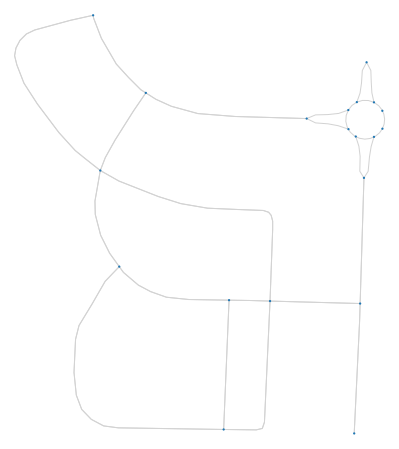

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [22]:
north, south, east, west = bb3[0],bb3[1],bb3[2],bb3[3]
# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

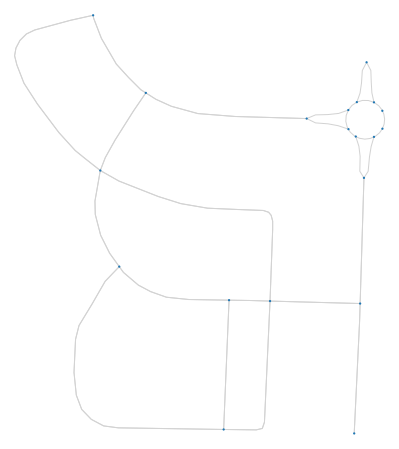

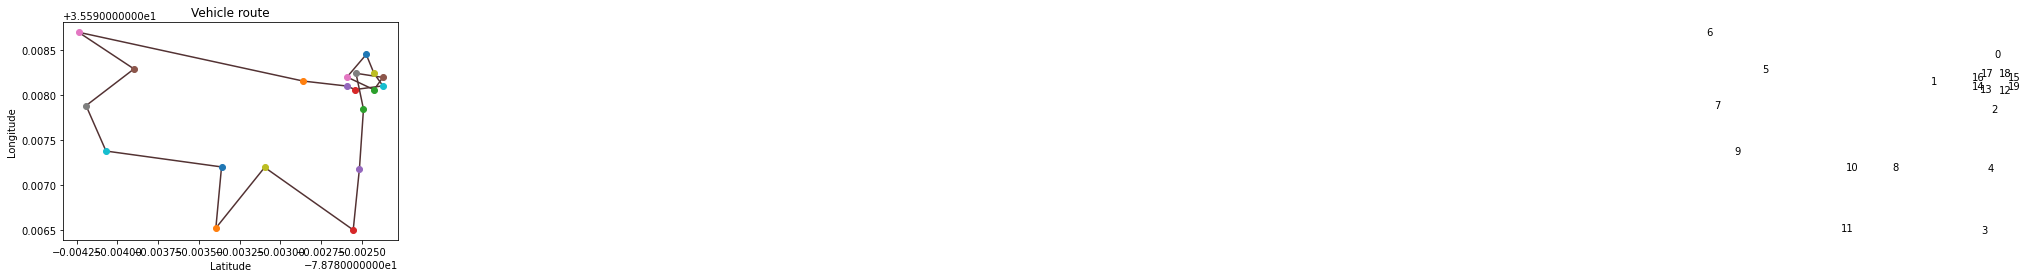

[[(2, 17), (17, 15), (15, 12), (12, 16), (16, 0), (0, 18), (18, 19), (19, 13), (13, 14), (14, 1), (1, 6), (6, 5), (5, 7), (7, 9), (9, 10), (10, 11), (11, 8), (8, 3), (3, 4), (4, 2)]]
2
17
15
12
16
0
18
19
13
14
1
6
5
7
9
10
11
8
3
4


In [23]:


#Creating a bounding box
north, south, east, west = bb3[0],bb3[1],bb3[2],bb3[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(data.index.stop):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [16]:
bb3

[35.596373, 35.59883, -78.784815, -78.78224]

In [10]:
bb4 = [35.598926,35.600409,-78.784841,-78.782202]

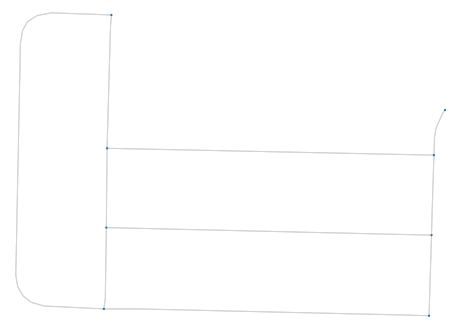

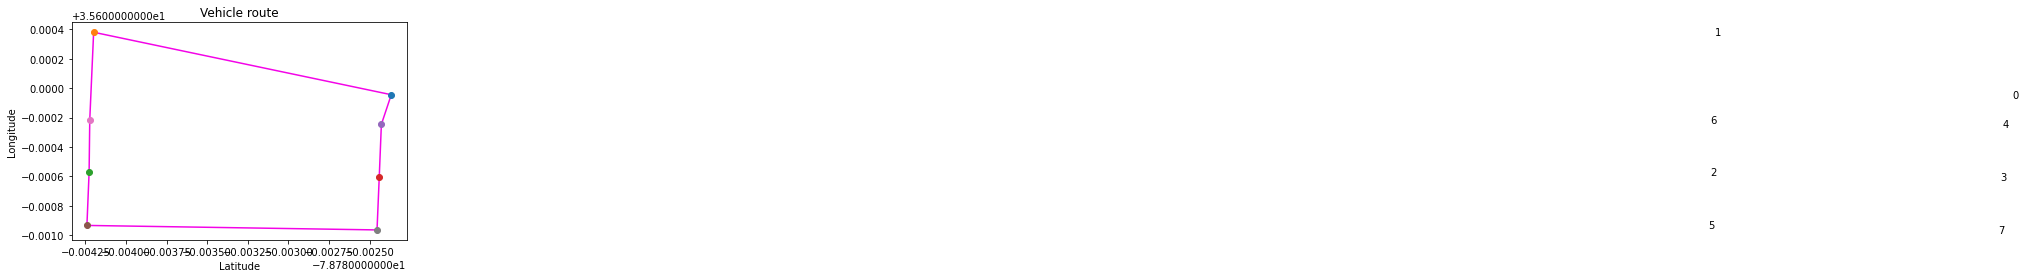

[[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]
2
6
1
0
4
3
7
5


In [26]:

#Creating a bounding box
north, south, east, west = bb4[0],bb4[1],bb4[2],bb4[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(data.index.stop):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
#order1 = [1,6,0,5,2]
#order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
#df4 = pd.DataFrame()
#for i in order2:
#    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
#df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
#df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

#df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
#for i in df4.index:
#    long3.append(df4.loc[i]["Longitude"])
#    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

#origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
#destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [27]:
routes

[[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]

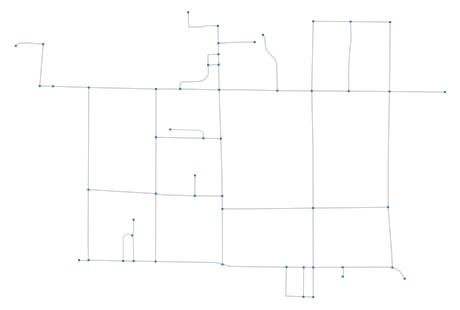

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [28]:
north, south, east, west = 35.581304,35.585510,-78.795250,-78.803511
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [11]:
bb

[[35.588654, 35.591812, -78.808848, -78.806101],
 [35.581702, 35.584546, -78.800222, -78.797915]]

In [12]:
bb.append(bb3)

In [13]:
bb.append(bb4)

In [14]:
bb

[[35.588654, 35.591812, -78.808848, -78.806101],
 [35.581702, 35.584546, -78.800222, -78.797915],
 [35.596373, 35.59883, -78.784815, -78.78224],
 [35.598926, 35.600409, -78.784841, -78.782202]]

In [15]:
nodelist = []
for i in range(4):
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]    
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    nodelist.append(G.nodes)

In [16]:
nodelist

[NodeView((195429022, 195493602, 195493610, 195493612, 195493614, 195516482, 195547925, 195585829, 195609957)),
 NodeView((195438253, 195438255, 195438631, 195447516, 195447518, 195447520, 195500922, 195594836, 6359366687, 7463971107, 7472627041, 7472627042, 8739204976, 8739204978)),
 NodeView((7231955403, 7231955438, 7231955439, 7231955441, 7231955442, 7231955495, 7231955496, 7231955510, 7231955522, 7231955534, 7443623617, 7443623620, 7443623634, 7443623641, 7443623642, 7443623655, 7443623679, 7443623681, 7443623684, 7443631189)),
 NodeView((7231955412, 7231955424, 7231955474, 7231955475, 7443631210, 7443631211, 7443631213, 7443631214))]

In [17]:
type(nodelist[0])

networkx.classes.reportviews.NodeView

In [18]:
nodelist[0]

NodeView((195429022, 195493602, 195493610, 195493612, 195493614, 195516482, 195547925, 195585829, 195609957))

In [19]:
separatednodelist = []
for i in nodelist:
    for j in i:
        #print(j)
        separatednodelist.append(j)

In [20]:
separatednodelist

[195429022,
 195493602,
 195493610,
 195493612,
 195493614,
 195516482,
 195547925,
 195585829,
 195609957,
 195438253,
 195438255,
 195438631,
 195447516,
 195447518,
 195447520,
 195500922,
 195594836,
 6359366687,
 7463971107,
 7472627041,
 7472627042,
 8739204976,
 8739204978,
 7231955403,
 7231955438,
 7231955439,
 7231955441,
 7231955442,
 7231955495,
 7231955496,
 7231955510,
 7231955522,
 7231955534,
 7443623617,
 7443623620,
 7443623634,
 7443623641,
 7443623642,
 7443623655,
 7443623679,
 7443623681,
 7443623684,
 7443631189,
 7231955412,
 7231955424,
 7231955474,
 7231955475,
 7443631210,
 7443631211,
 7443631213,
 7443631214]

In [21]:
import pandas as pd
data = pd.DataFrame(separatednodelist)
data.rename(columns = {0:'Nodes'}, inplace = True)
data

Nodes
0    195429022
1    195493602
2    195493610
3    195493612
4    195493614
5    195516482
6    195547925
7    195585829
8    195609957
9    195438253
10   195438255
11   195438631
12   195447516
13   195447518
14   195447520
15   195500922
16   195594836
17  6359366687
18  7463971107
19  7472627041
20  7472627042
21  8739204976
22  8739204978
23  7231955403
24  7231955438
25  7231955439
26  7231955441
27  7231955442
28  7231955495
29  7231955496
30  7231955510
31  7231955522
32  7231955534
33  7443623617
34  7443623620
35  7443623634
36  7443623641
37  7443623642
38  7443623655
39  7443623679
40  7443623681
41  7443623684
42  7443631189
43  7231955412
44  7231955424
45  7231955474
46  7231955475
47  7443631210
48  7443631211
49  7443631213
50  7443631214

In [22]:
data1 = pd.DataFrame()
data1.rename(columns = {0:'Nodes'}, inplace = True)
for i in range(4):
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]    
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)
    lat1 = []
    long1 = []
    data2 = pd.DataFrame(Nodes)
    data2.rename(columns = {0:'Nodes'}, inplace = True)
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data2['Latitude'] = lat1
    data2['Longitude'] = long1     
    data1 = data1.append(data2, ignore_index=True)


In [23]:
data1

Nodes   Latitude  Longitude
0    195429022  35.588736 -78.806190
1    195493602  35.588994 -78.808794
2    195493610  35.589881 -78.808785
3    195493612  35.590787 -78.808779
4    195493614  35.591706 -78.808766
5    195516482  35.589768 -78.806350
6    195547925  35.588915 -78.807612
7    195585829  35.590683 -78.806481
8    195609957  35.591581 -78.806431
9    195438253  35.582010 -78.799760
10   195438255  35.581969 -78.798268
11   195438631  35.584332 -78.798292
12   195447516  35.582924 -78.799764
13   195447518  35.583693 -78.799788
14   195447520  35.584345 -78.799816
15   195500922  35.582764 -78.798270
16   195594836  35.582753 -78.799763
17  6359366687  35.584334 -78.798859
18  7463971107  35.583698 -78.800076
19  7472627041  35.582927 -78.800216
20  7472627042  35.583201 -78.800213
21  8739204976  35.581971 -78.798425
22  8739204978  35.581973 -78.798708
23  7231955403  35.598450 -78.782474
24  7231955438  35.598155 -78.782861
25  7231955439  35.597844 -78.782491
26  7231955441  35.596503 -78.782554
27  7231955442  35.597184 -78.782516
28  7231955495  35.598289 -78.783898
29  7231955496  35.598696 -78.784238
30  7231955510  35.597882 -78.784192
31  7231955522  35.597197 -78.783097
32  7231955534  35.597378 -78.784070
33  7443623617  35.597202 -78.783361
34  7443623620  35.596524 -78.783396
35  7443623634  35.598059 -78.782426
36  7443623641  35.598060 -78.782544
37  7443623642  35.598099 -78.782591
38  7443623655  35.598195 -78.782372
39  7443623679  35.598199 -78.782592
40  7443623681  35.598241 -78.782537
41  7443623684  35.598240 -78.782427
42  7443631189  35.598101 -78.782372
43  7231955412  35.599955 -78.782367
44  7231955424  35.600380 -78.784200
45  7231955474  35.599430 -78.784228
46  7231955475  35.599396 -78.782441
47  7443631210  35.599754 -78.782428
48  7443631211  35.599067 -78.784241
49  7443631213  35.599784 -78.784224
50  7443631214  35.599036 -78.782455

In [24]:
def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()

In [25]:
long = [] 
lat = []  
for i in data1.index:
    long.append(data1.loc[i]["Longitude"])
    lat.append(data1.loc[i]["Latitude"])
origin_point = (data1.loc[0]["Latitude"], data1.loc[0]["Longitude"]) 
destination_point = (data1.iloc[-1]["Latitude"], data1.iloc[-1]["Longitude"]) 
plot_path(lat, long, origin_point, destination_point)

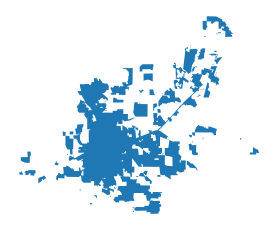

In [26]:
import osmnx as ox
city = ox.geocode_to_gdf('Fuquay Varina, NC, USA')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

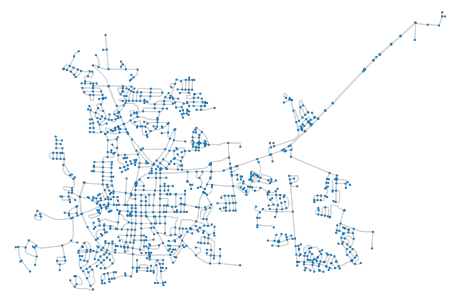

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [70]:
import matplotlib.pyplot as plt 
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [28]:
nodelist

[NodeView((195429022, 195493602, 195493610, 195493612, 195493614, 195516482, 195547925, 195585829, 195609957)),
 NodeView((195438253, 195438255, 195438631, 195447516, 195447518, 195447520, 195500922, 195594836, 6359366687, 7463971107, 7472627041, 7472627042, 8739204976, 8739204978)),
 NodeView((7231955403, 7231955438, 7231955439, 7231955441, 7231955442, 7231955495, 7231955496, 7231955510, 7231955522, 7231955534, 7443623617, 7443623620, 7443623634, 7443623641, 7443623642, 7443623655, 7443623679, 7443623681, 7443623684, 7443631189)),
 NodeView((7231955412, 7231955424, 7231955474, 7231955475, 7443631210, 7443631211, 7443631213, 7443631214))]

In [29]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [30]:
path2 = nx.shortest_path(G, 195609957,195438253, weight='travel_time')

In [31]:
path2

[195609957,
 195585829,
 195516482,
 195429022,
 195429017,
 1278913141,
 195429011,
 195429001,
 195475328,
 195556052,
 195602233,
 4291074049,
 195522045,
 195475310,
 195475306,
 195456444,
 195438253]

In [32]:
data3 = pd.DataFrame(path2)
data3.rename(columns = {0:'Nodes'}, inplace = True)
data3

Nodes
0    195609957
1    195585829
2    195516482
3    195429022
4    195429017
5   1278913141
6    195429011
7    195429001
8    195475328
9    195556052
10   195602233
11  4291074049
12   195522045
13   195475310
14   195475306
15   195456444
16   195438253

In [33]:
lat1 = []
long1 = []
for i in path2:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))

In [34]:
data3['Latitude'] = lat1
data3['Longitude'] = long1

In [35]:
data3

Nodes   Latitude  Longitude
0    195609957  35.591581 -78.806431
1    195585829  35.590683 -78.806481
2    195516482  35.589768 -78.806350
3    195429022  35.588736 -78.806190
4    195429017  35.587468 -78.805855
5   1278913141  35.587031 -78.805836
6    195429011  35.586188 -78.805847
7    195429001  35.584447 -78.805745
8    195475328  35.584434 -78.805028
9    195556052  35.584422 -78.804397
10   195602233  35.584397 -78.802768
11  4291074049  35.584393 -78.802548
12   195522045  35.584377 -78.801961
13   195475310  35.583010 -78.801967
14   195475306  35.582957 -78.800859
15   195456444  35.582049 -78.800862
16   195438253  35.582010 -78.799760

In [36]:
origin_point = (data3.loc[0]["Latitude"], data3.loc[0]["Longitude"]) 
destination_point = (data3.iloc[-1]["Latitude"], data3.iloc[-1]["Longitude"])

In [37]:
plot_path(lat1, long1, origin_point, destination_point)

In [44]:
path1 = nx.shortest_path(G, 195594836,7231955403, weight='travel_time')
data4 = pd.DataFrame(path1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in path1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
plot_path(lat1, long1, origin_point, destination_point)

In [45]:
data1

Nodes   Latitude  Longitude
0    195429022  35.588736 -78.806190
1    195493602  35.588994 -78.808794
2    195493610  35.589881 -78.808785
3    195493612  35.590787 -78.808779
4    195493614  35.591706 -78.808766
5    195516482  35.589768 -78.806350
6    195547925  35.588915 -78.807612
7    195585829  35.590683 -78.806481
8    195609957  35.591581 -78.806431
9    195438253  35.582010 -78.799760
10   195438255  35.581969 -78.798268
11   195438631  35.584332 -78.798292
12   195447516  35.582924 -78.799764
13   195447518  35.583693 -78.799788
14   195447520  35.584345 -78.799816
15   195500922  35.582764 -78.798270
16   195594836  35.582753 -78.799763
17  6359366687  35.584334 -78.798859
18  7463971107  35.583698 -78.800076
19  7472627041  35.582927 -78.800216
20  7472627042  35.583201 -78.800213
21  8739204976  35.581971 -78.798425
22  8739204978  35.581973 -78.798708
23  7231955403  35.598450 -78.782474
24  7231955438  35.598155 -78.782861
25  7231955439  35.597844 -78.782491
26  7231955441  35.596503 -78.782554
27  7231955442  35.597184 -78.782516
28  7231955495  35.598289 -78.783898
29  7231955496  35.598696 -78.784238
30  7231955510  35.597882 -78.784192
31  7231955522  35.597197 -78.783097
32  7231955534  35.597378 -78.784070
33  7443623617  35.597202 -78.783361
34  7443623620  35.596524 -78.783396
35  7443623634  35.598059 -78.782426
36  7443623641  35.598060 -78.782544
37  7443623642  35.598099 -78.782591
38  7443623655  35.598195 -78.782372
39  7443623679  35.598199 -78.782592
40  7443623681  35.598241 -78.782537
41  7443623684  35.598240 -78.782427
42  7443631189  35.598101 -78.782372
43  7231955412  35.599955 -78.782367
44  7231955424  35.600380 -78.784200
45  7231955474  35.599430 -78.784228
46  7231955475  35.599396 -78.782441
47  7443631210  35.599754 -78.782428
48  7443631211  35.599067 -78.784241
49  7443631213  35.599784 -78.784224
50  7443631214  35.599036 -78.782455

In [46]:
data3

Nodes   Latitude  Longitude
0    195609957  35.591581 -78.806431
1    195585829  35.590683 -78.806481
2    195516482  35.589768 -78.806350
3    195429022  35.588736 -78.806190
4    195429017  35.587468 -78.805855
5   1278913141  35.587031 -78.805836
6    195429011  35.586188 -78.805847
7    195429001  35.584447 -78.805745
8    195475328  35.584434 -78.805028
9    195556052  35.584422 -78.804397
10   195602233  35.584397 -78.802768
11  4291074049  35.584393 -78.802548
12   195522045  35.584377 -78.801961
13   195475310  35.583010 -78.801967
14   195475306  35.582957 -78.800859
15   195456444  35.582049 -78.800862
16   195438253  35.582010 -78.799760

In [47]:
data4

Nodes   Latitude  Longitude
0    195594836  35.582753 -78.799763
1    195500922  35.582764 -78.798270
2    195594842  35.582774 -78.797035
3    195631802  35.584323 -78.797013
4    195631803  35.584315 -78.796100
5    195623949  35.584313 -78.794945
6    195631804  35.584299 -78.793169
7    195461517  35.584295 -78.791994
8    195631805  35.584292 -78.791346
9    195631807  35.584284 -78.791026
10   195631809  35.584002 -78.789822
11   195532485  35.584012 -78.788860
12   195434615  35.584601 -78.787511
13   195517868  35.584615 -78.787238
14   195550222  35.584515 -78.786528
15  6548460942  35.584485 -78.786338
16  8224744959  35.583970 -78.783274
17  8224744958  35.583957 -78.783192
18   195631831  35.583850 -78.782509
19  8224913086  35.587184 -78.781344
20  8224913087  35.587263 -78.781296
21   195467696  35.587946 -78.780896
22  6515792453  35.588973 -78.780276
23  6515758248  35.590273 -78.779366
24   195640581  35.591826 -78.779053
25  6521445630  35.593706 -78.779267
26   195619412  35.594935 -78.774272
27  7373321131  35.598173 -78.774494
28  5434186648  35.597768 -78.779837
29  7443631263  35.597982 -78.780638
30  7443631241  35.598043 -78.780680
31  7443631252  35.598050 -78.780772
32  7231955400  35.598107 -78.781063
33  7443631243  35.598141 -78.782102
34  7443623655  35.598195 -78.782372
35  7443623684  35.598240 -78.782427
36  7231955403  35.598450 -78.782474

In [48]:
#need to put data3 and data4 between data1 for seamless flow of path.
#data3 to go between 8 and 9 in data1
#data4 to go between 16 and 17 in data1

In [49]:
data1.loc[:8]

Nodes   Latitude  Longitude
0  195429022  35.588736 -78.806190
1  195493602  35.588994 -78.808794
2  195493610  35.589881 -78.808785
3  195493612  35.590787 -78.808779
4  195493614  35.591706 -78.808766
5  195516482  35.589768 -78.806350
6  195547925  35.588915 -78.807612
7  195585829  35.590683 -78.806481
8  195609957  35.591581 -78.806431

In [50]:
finaldf = pd.concat([data1.loc[:7],data3,data1[10:15],data4,data1[17:]],axis=0)

In [51]:
finaldf

Nodes   Latitude  Longitude
0    195429022  35.588736 -78.806190
1    195493602  35.588994 -78.808794
2    195493610  35.589881 -78.808785
3    195493612  35.590787 -78.808779
4    195493614  35.591706 -78.808766
..         ...        ...        ...
46  7231955475  35.599396 -78.782441
47  7443631210  35.599754 -78.782428
48  7443631211  35.599067 -78.784241
49  7443631213  35.599784 -78.784224
50  7443631214  35.599036 -78.782455

[101 rows x 3 columns]

In [52]:
finaldf.reset_index(inplace = True)
long = [] 
lat = []  
for i in finaldf.index:
    long.append(finaldf.loc[i]["Longitude"])
    lat.append(finaldf.loc[i]["Latitude"])
origin_point = (finaldf.loc[0]["Latitude"], finaldf.loc[0]["Longitude"]) 
destination_point = (finaldf.iloc[-1]["Latitude"], finaldf.iloc[-1]["Longitude"])
plot_path(lat, long, origin_point, destination_point)

In [53]:
bb

[[35.588654, 35.591812, -78.808848, -78.806101],
 [35.581702, 35.584546, -78.800222, -78.797915],
 [35.596373, 35.59883, -78.784815, -78.78224],
 [35.598926, 35.600409, -78.784841, -78.782202]]

In [54]:
finaldf.reset_index(inplace = True)
long = [] 
lat = []  
for i in finaldf.index:
    long.append(finaldf.loc[i]["Longitude"])
    lat.append(finaldf.loc[i]["Latitude"])
origin_point = (finaldf.loc[0]["Latitude"], finaldf.loc[0]["Longitude"]) 
destination_point = (finaldf.iloc[-1]["Latitude"], finaldf.iloc[-1]["Longitude"])
plot_path(lat, long, origin_point, destination_point)

In [55]:
finalroutes = []

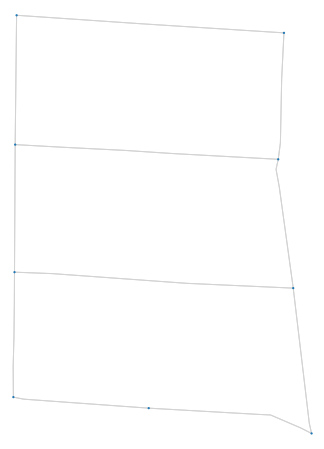

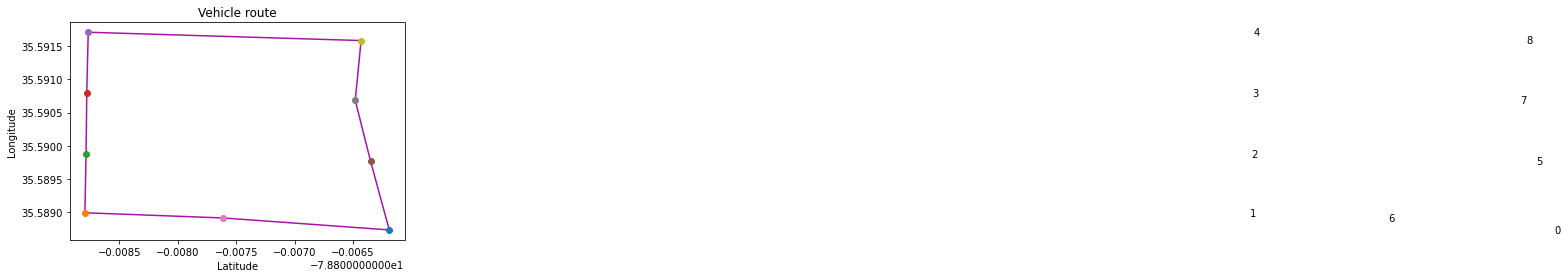

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]
2
1
6
0
5
7
8
4
3


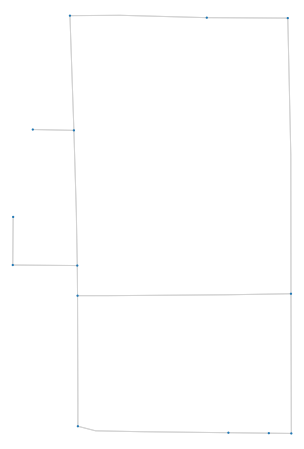

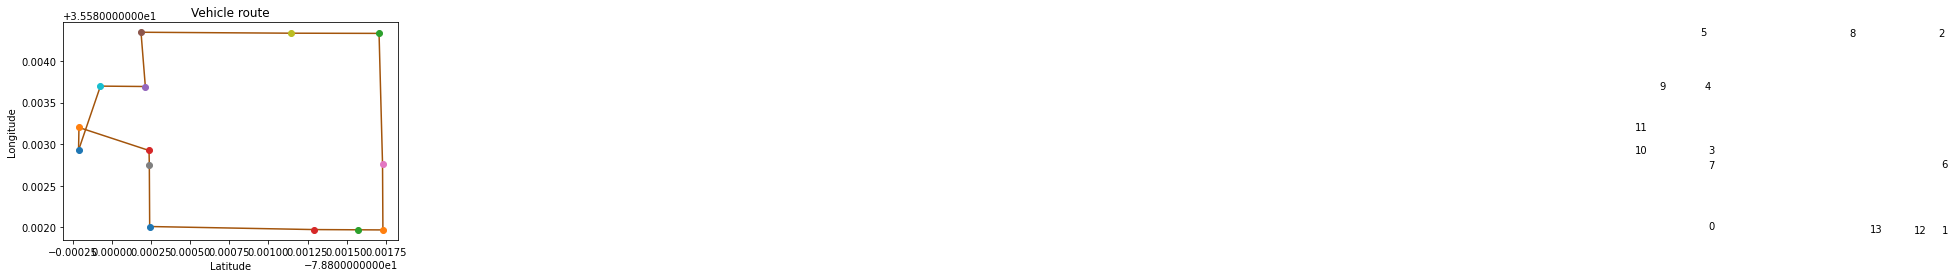

[[(2, 8), (8, 5), (5, 4), (4, 9), (9, 10), (10, 11), (11, 3), (3, 7), (7, 0), (0, 13), (13, 12), (12, 1), (1, 6), (6, 2)]]
2
8
5
4
9
10
11
3
7
0
13
12
1
6


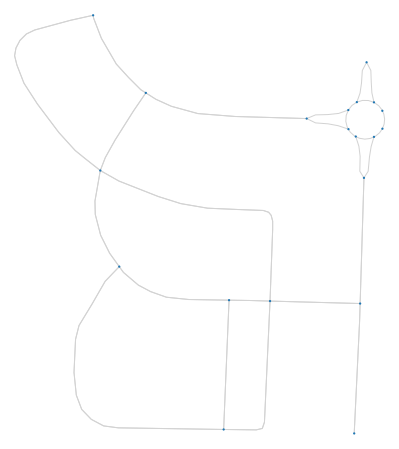

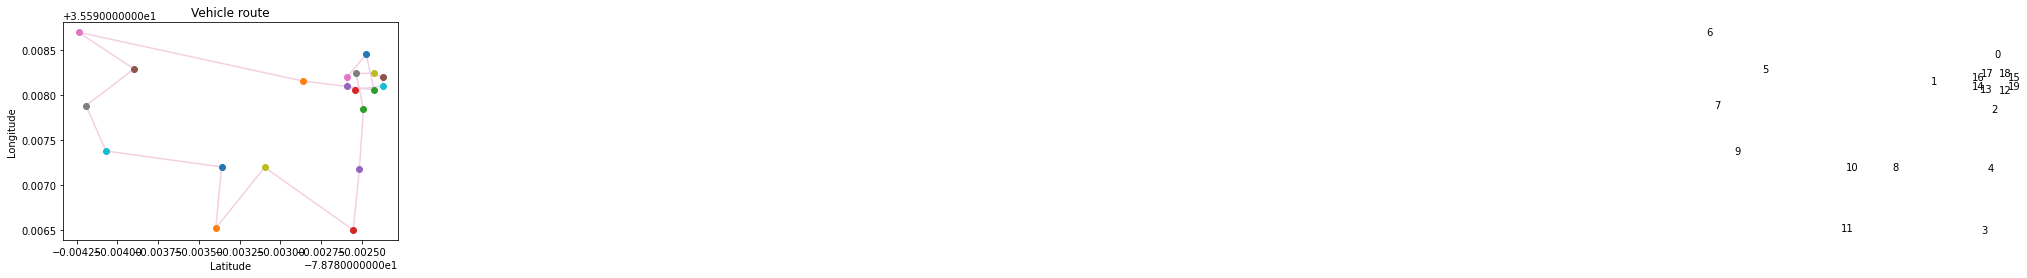

[[(2, 17), (17, 18), (18, 15), (15, 19), (19, 13), (13, 14), (14, 16), (16, 0), (0, 12), (12, 1), (1, 6), (6, 5), (5, 7), (7, 9), (9, 10), (10, 11), (11, 8), (8, 3), (3, 4), (4, 2)]]
2
17
18
15
19
13
14
16
0
12
1
6
5
7
9
10
11
8
3
4


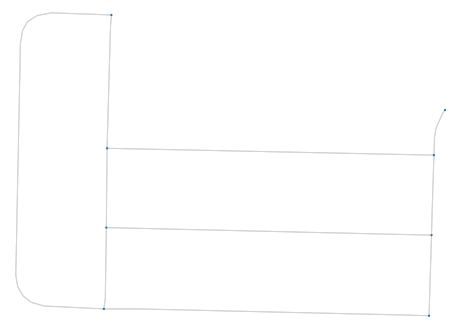

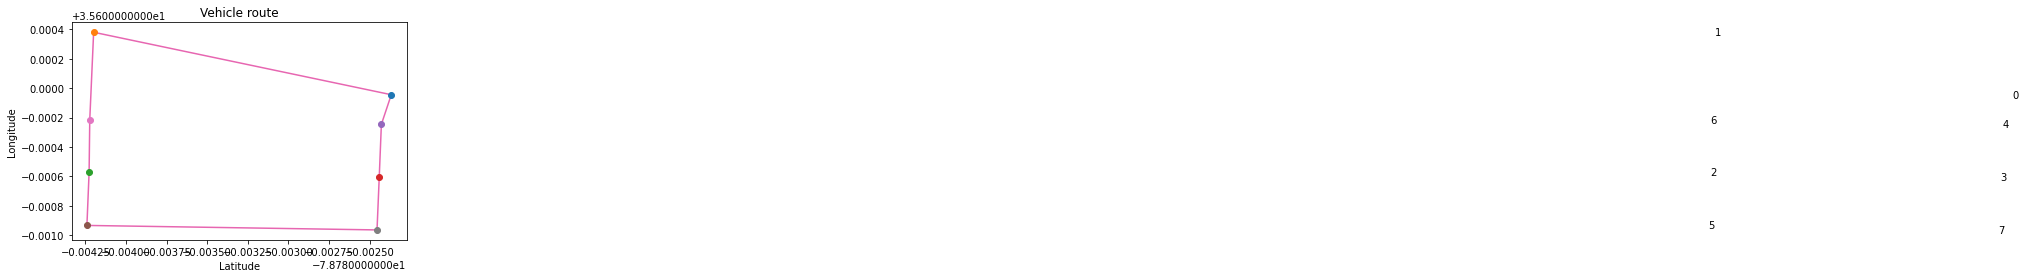

[[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]
2
6
1
0
4
3
7
5


In [56]:
for i in range(4):
    
    #Creating a bounding box
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]    
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)

    data = pd.DataFrame(Nodes)
    data.rename(columns = {0:'Nodes'}, inplace = True)

    lat1 = []
    long1 = []
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data['Latitude'] = lat1
    data['Longitude'] = long1
    df1 = data


    df1 = df1.drop(['Nodes'],axis=1)
    df1.rename(columns = {'Latitude':'Left'}, inplace = True)
    df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
    df3 = pd.DataFrame()
    for j in df1.index:
        list1 = []
        for i in df1.index:
            r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
            list1.append(json.loads(r.content)["routes"][0]["distance"])
        df3[j] = list1
    df = df1
    df['coordinate'] = list(zip(df['Right'],df['Left']))
    df['ID'] = df.index

    locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
    distances_df = df3
    distance = distances_df
    distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
    V = 1
    ## prob: This initializes the problem that will run using provided constraints.

    prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
    indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
    eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
    cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    start1 = 2
    for v in df.ID:
        ## cap: This considers a particular node at a time. 
        cap = 1 if v != start1 else V
        #inward possible route
        prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
        prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
    num=len(df.ID)/V
    for i in df.ID:
        for j in df.ID:
            if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
                prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
    prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
    feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
    def get_next_loc(initial):
        edges = [e for e in feasible_edges if e[0]==initial]
        for e in edges:
            feasible_edges.remove(e)
        return edges
    ## routes: This stores information regarding paths.    
    routes = get_next_loc(2)
    routes = [ [e] for e in routes ]

    for r in routes:
        while r[-1][1] !=start1:
            r.append(get_next_loc(r[-1][1])[-1])
    ## coloured_loc: This stores information according to individual paths.        
    coloured_loc = [np.random.rand(3) for i in range(len(routes))]
    for r,co in zip(routes,coloured_loc):
        for a,b in r:
            l1,l2 = locations[a], locations[b]
            plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
    for l in locations:
        lo = locations[l]
        plt.plot(lo[0],lo[1],'o')
        plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')


    plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()        
    finalroutes.append(routes)
    print(routes)



    df2 = df[['Left', 'Right', 'ID']].copy()
    df2.rename(columns = {'Left':'Latitude'}, inplace = True)
    df2.rename(columns = {'Right':'Longitude'}, inplace = True)
    a=[]
    for i in range(data.index.stop):
        print(routes[0][i][0])
        a.append(routes[0][i][0]) 

    df3 = pd.DataFrame()
    for i in a:
        df3 = df3.append(df2.loc[i])

    df3.reset_index(inplace = True)

    df3 = df3.append(df3.loc[0])
    df3.reset_index(inplace = True)
    long2 = [] 
    lat2 = []  
    for i in df3.index:
        long2.append(df3.loc[i]["Longitude"])
        lat2.append(df3.loc[i]["Latitude"])


    def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()


    origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
    destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
    plot_path(lat2, long2, origin_point2, destination_point2)



In [57]:
finalroutes

[[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]],
 [[(2, 8),
   (8, 5),
   (5, 4),
   (4, 9),
   (9, 10),
   (10, 11),
   (11, 3),
   (3, 7),
   (7, 0),
   (0, 13),
   (13, 12),
   (12, 1),
   (1, 6),
   (6, 2)]],
 [[(2, 17),
   (17, 18),
   (18, 15),
   (15, 19),
   (19, 13),
   (13, 14),
   (14, 16),
   (16, 0),
   (0, 12),
   (12, 1),
   (1, 6),
   (6, 5),
   (5, 7),
   (7, 9),
   (9, 10),
   (10, 11),
   (11, 8),
   (8, 3),
   (3, 4),
   (4, 2)]],
 [[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]]

In [63]:
finalroutes[0][0]

[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]

In [64]:
nodelist

[NodeView((195429022, 195493602, 195493610, 195493612, 195493614, 195516482, 195547925, 195585829, 195609957)),
 NodeView((195438253, 195438255, 195438631, 195447516, 195447518, 195447520, 195500922, 195594836, 6359366687, 7463971107, 7472627041, 7472627042, 8739204976, 8739204978)),
 NodeView((7231955403, 7231955438, 7231955439, 7231955441, 7231955442, 7231955495, 7231955496, 7231955510, 7231955522, 7231955534, 7443623617, 7443623620, 7443623634, 7443623641, 7443623642, 7443623655, 7443623679, 7443623681, 7443623684, 7443631189)),
 NodeView((7231955412, 7231955424, 7231955474, 7231955475, 7443631210, 7443631211, 7443631213, 7443631214))]

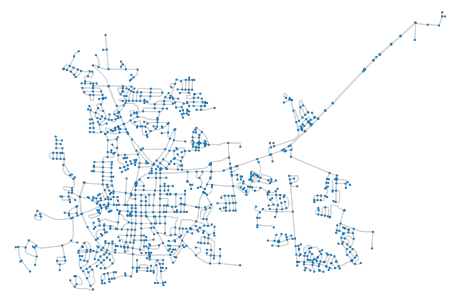

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [71]:
import matplotlib.pyplot as plt 
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [75]:
finalroutes[0][0]

[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]

In [85]:
box1 = pd.DataFrame(nodelist[0])
route1 = [2,1,6,0,5,7,8,4,3]
box1.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in nodelist[0]:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
box1['Latitude'] = lat1
box1['Longitude'] = long1
bbox1 = pd.DataFrame()
for i in route1:
    bbox1 = bbox1.append(box1.loc[i])
bbox1.reset_index(inplace = True)
bbox1

index        Nodes   Latitude  Longitude
0      2  195493610.0  35.589881 -78.808785
1      1  195493602.0  35.588994 -78.808794
2      6  195547925.0  35.588915 -78.807612
3      0  195429022.0  35.588736 -78.806190
4      5  195516482.0  35.589768 -78.806350
5      7  195585829.0  35.590683 -78.806481
6      8  195609957.0  35.591581 -78.806431
7      4  195493614.0  35.591706 -78.808766
8      3  195493612.0  35.590787 -78.808779

In [98]:
nodes = [195438253, 195438255, 195438631, 195447516, 195447518, 195447520, 195500922, 195594836]
box2 = pd.DataFrame(nodes)
route2 = [2,5,4,3,7,0,1,6]
box2.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
box2['Latitude'] = lat1
box2['Longitude'] = long1
bbox2 = pd.DataFrame()
for i in route2:
    bbox2 = bbox2.append(box2.loc[i])
bbox2.reset_index(inplace = True)
bbox2

index        Nodes   Latitude  Longitude
0      2  195438631.0  35.584332 -78.798292
1      5  195447520.0  35.584345 -78.799816
2      4  195447518.0  35.583693 -78.799788
3      3  195447516.0  35.582924 -78.799764
4      7  195594836.0  35.582753 -78.799763
5      0  195438253.0  35.582010 -78.799760
6      1  195438255.0  35.581969 -78.798268
7      6  195500922.0  35.582764 -78.798270

In [96]:
box3 = pd.DataFrame(nodelist[2])
route3 = [2,17,18,15,19,13,14,16,0,12,1,6,5,7,9,10,11,8,3,4]
box3.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in nodelist[2]:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
box3['Latitude'] = lat1
box3['Longitude'] = long1
bbox3 = pd.DataFrame()
for i in route3:
    bbox3 = bbox3.append(box3.loc[i])
bbox3.reset_index(inplace = True)
bbox3

index         Nodes   Latitude  Longitude
0       2  7.231955e+09  35.597844 -78.782491
1      17  7.443624e+09  35.598241 -78.782537
2      18  7.443624e+09  35.598240 -78.782427
3      15  7.443624e+09  35.598195 -78.782372
4      19  7.443631e+09  35.598101 -78.782372
5      13  7.443624e+09  35.598060 -78.782544
6      14  7.443624e+09  35.598099 -78.782591
7      16  7.443624e+09  35.598199 -78.782592
8       0  7.231955e+09  35.598450 -78.782474
9      12  7.443624e+09  35.598059 -78.782426
10      1  7.231955e+09  35.598155 -78.782861
11      6  7.231955e+09  35.598696 -78.784238
12      5  7.231955e+09  35.598289 -78.783898
13      7  7.231956e+09  35.597882 -78.784192
14      9  7.231956e+09  35.597378 -78.784070
15     10  7.443624e+09  35.597202 -78.783361
16     11  7.443624e+09  35.596524 -78.783396
17      8  7.231956e+09  35.597197 -78.783097
18      3  7.231955e+09  35.596503 -78.782554
19      4  7.231955e+09  35.597184 -78.782516

In [103]:
bb4 = [35.598926,35.600409,-78.784841,-78.782202]
north, south, east, west = 35.598926,35.600409,-78.784841,-78.782202
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
box4 = pd.DataFrame(nodelist[3])
route4 = [2,6,1,0,4,3,7,5]
box4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in nodelist[3]:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
box4['Latitude'] = lat1
box4['Longitude'] = long1
bbox4 = pd.DataFrame()
for i in route4:
    bbox4 = bbox4.append(box4.loc[i])
bbox4.reset_index(inplace = True)
bbox4

index         Nodes   Latitude  Longitude
0      2  7.231955e+09  35.599430 -78.784228
1      6  7.443631e+09  35.599784 -78.784224
2      1  7.231955e+09  35.600380 -78.784200
3      0  7.231955e+09  35.599955 -78.782367
4      4  7.443631e+09  35.599754 -78.782428
5      3  7.231955e+09  35.599396 -78.782441
6      7  7.443631e+09  35.599036 -78.782455
7      5  7.443631e+09  35.599067 -78.784241

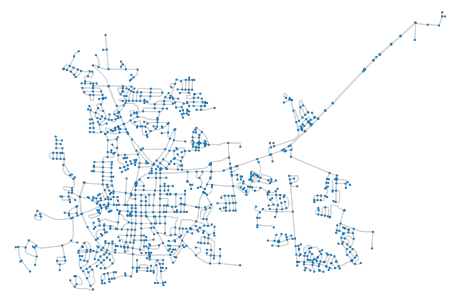

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [104]:
import matplotlib.pyplot as plt 
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [109]:
bbox1.iloc[-1]['Nodes']

195493612.0

In [112]:
path1_2 = nx.shortest_path(G, bbox1.iloc[-1]['Nodes'],bbox2.iloc[0]['Nodes'], weight='travel_time')
bboxm1 = pd.DataFrame(path1_2)
bboxm1.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in path1_2:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
bboxm1['Latitude'] = lat1
bboxm1['Longitude'] = long1
bboxm1

Nodes   Latitude  Longitude
0   1.954936e+08  35.590787 -78.808779
1   1.954936e+08  35.589881 -78.808785
2   1.955165e+08  35.589768 -78.806350
3   1.954290e+08  35.588736 -78.806190
4   1.954290e+08  35.587468 -78.805855
5   1.956022e+08  35.587085 -78.802503
6   1.956796e+08  35.586936 -78.801129
7   4.291074e+09  35.584393 -78.802548
8   1.955220e+08  35.584377 -78.801961
9   1.956530e+08  35.584357 -78.800853
10  1.954475e+08  35.584345 -78.799816
11  1.954386e+08  35.584332 -78.798292

In [113]:
path2_3 = nx.shortest_path(G, bbox2.iloc[-1]['Nodes'],bbox3.iloc[0]['Nodes'], weight='travel_time')
bboxm2 = pd.DataFrame(path2_3)
bboxm2.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in path2_3:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
bboxm2['Latitude'] = lat1
bboxm2['Longitude'] = long1
bboxm2

Nodes   Latitude  Longitude
0   1.955009e+08  35.582764 -78.798270
1   1.955948e+08  35.582774 -78.797035
2   1.955948e+08  35.582792 -78.794975
3   1.956239e+08  35.584313 -78.794945
4   1.957032e+08  35.586699 -78.794712
5   1.957001e+08  35.587632 -78.794495
6   1.956876e+08  35.590434 -78.794237
7   1.956637e+08  35.590438 -78.793068
8   1.956637e+08  35.591462 -78.793066
9   1.954886e+08  35.591768 -78.785609
10  1.954196e+08  35.591806 -78.783141
11  1.955796e+08  35.591816 -78.781553
12  6.521446e+09  35.591825 -78.779192
13  1.956406e+08  35.591826 -78.779053
14  6.521446e+09  35.593706 -78.779267
15  1.956194e+08  35.594935 -78.774272
16  7.373321e+09  35.598173 -78.774494
17  5.434187e+09  35.597768 -78.779837
18  7.231955e+09  35.600643 -78.781694
19  7.231955e+09  35.599955 -78.782367
20  7.231955e+09  35.599396 -78.782441
21  7.231955e+09  35.599430 -78.784228
22  7.231955e+09  35.598696 -78.784238
23  7.231956e+09  35.597882 -78.784192
24  7.231956e+09  35.597197 -78.783097
25  7.231955e+09  35.597184 -78.782516
26  7.231955e+09  35.597844 -78.782491

In [120]:
path3_4 = nx.shortest_path(G, bbox3.iloc[-1]['Nodes'],bbox4.iloc[0]['Nodes'], weight='travel_time')
bboxm3 = pd.DataFrame(path3_4)
bboxm3.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in path3_4:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
bboxm3['Latitude'] = lat1
bboxm3['Longitude'] = long1
bboxm3

Nodes   Latitude  Longitude
0  7.231955e+09  35.597184 -78.782516
1  7.231956e+09  35.597197 -78.783097
2  7.231956e+09  35.597882 -78.784192
3  7.231955e+09  35.598696 -78.784238
4  7.231955e+09  35.599430 -78.784228

In [121]:
finalpath = pd.concat([bbox1, bboxm1, bbox2, bboxm2, bbox3, bboxm3, bbox4],axis=0)

In [122]:
finalpath

index         Nodes   Latitude  Longitude
0     2.0  1.954936e+08  35.589881 -78.808785
1     1.0  1.954936e+08  35.588994 -78.808794
2     6.0  1.955479e+08  35.588915 -78.807612
3     0.0  1.954290e+08  35.588736 -78.806190
4     5.0  1.955165e+08  35.589768 -78.806350
..    ...           ...        ...        ...
3     0.0  7.231955e+09  35.599955 -78.782367
4     4.0  7.443631e+09  35.599754 -78.782428
5     3.0  7.231955e+09  35.599396 -78.782441
6     7.0  7.443631e+09  35.599036 -78.782455
7     5.0  7.443631e+09  35.599067 -78.784241

[89 rows x 4 columns]

In [124]:
finalpath.reset_index(inplace = True)
long = [] 
lat = []  
for i in finalpath.index:
    long.append(finalpath.loc[i]["Longitude"])
    lat.append(finalpath.loc[i]["Latitude"])
origin_point = (finalpath.loc[0]["Latitude"], finalpath.loc[0]["Longitude"]) 
destination_point = (finalpath.iloc[-1]["Latitude"], finalpath.iloc[-1]["Longitude"])
plot_path(lat, long, origin_point, destination_point)

In [129]:
path2_4 = nx.shortest_path(G, bbox2.iloc[-1]['Nodes'],bbox4.iloc[0]['Nodes'], weight='travel_time')
bboxm4 = pd.DataFrame(path2_4)
bboxm4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
for i in path2_4:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
bboxm4['Latitude'] = lat1
bboxm4['Longitude'] = long1
bboxm4

Nodes   Latitude  Longitude
0   1.955009e+08  35.582764 -78.798270
1   1.955948e+08  35.582774 -78.797035
2   1.955948e+08  35.582792 -78.794975
3   1.956239e+08  35.584313 -78.794945
4   1.957032e+08  35.586699 -78.794712
5   1.957001e+08  35.587632 -78.794495
6   1.956876e+08  35.590434 -78.794237
7   1.956637e+08  35.590438 -78.793068
8   1.956637e+08  35.591462 -78.793066
9   1.954886e+08  35.591768 -78.785609
10  1.954196e+08  35.591806 -78.783141
11  1.955796e+08  35.591816 -78.781553
12  6.521446e+09  35.591825 -78.779192
13  1.956406e+08  35.591826 -78.779053
14  6.521446e+09  35.593706 -78.779267
15  1.956194e+08  35.594935 -78.774272
16  7.373321e+09  35.598173 -78.774494
17  5.434187e+09  35.597768 -78.779837
18  7.231955e+09  35.600643 -78.781694
19  7.231955e+09  35.599955 -78.782367
20  7.231955e+09  35.599396 -78.782441
21  7.231955e+09  35.599430 -78.784228

In [132]:
finalpath1 = pd.concat([bbox1, bboxm1, bbox2, bboxm4, bbox4],axis=0)

In [133]:
finalpath1.reset_index(inplace = True)
long = [] 
lat = []  
for i in finalpath1.index:
    long.append(finalpath1.loc[i]["Longitude"])
    lat.append(finalpath1.loc[i]["Latitude"])
origin_point = (finalpath1.loc[0]["Latitude"], finalpath1.loc[0]["Longitude"]) 
destination_point = (finalpath1.iloc[-1]["Latitude"], finalpath1.iloc[-1]["Longitude"])
plot_path(lat, long, origin_point, destination_point)